In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier  # Import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from scipy.stats import zscore

In [2]:
data = pd.read_csv("D:/dataset/diabetes1.csv")

In [3]:
# Replace 'No Info' with NaN in the 'smoking_history' column
data['smoking_history'] = data['smoking_history'].replace('No Info', np.NaN)

# Fill missing values in 'smoking_history' with mode
mode_value = data['smoking_history'].mode()[0]
data['smoking_history'].fillna(mode_value, inplace=True)

# Drop rows with 'gender' as 'Other'
data.drop(data[data['gender'] == 'Other'].index, inplace=True)

# MAPPING

In [4]:
# Define mappings for 'smoking_history' and 'gender'
smoking_history_mapping = {'never': 0, 'current': 1, 'former': 2, 'ever': 3, 'not current': 4}
gender_mapping = {'Female': 0, 'Male': 1}

In [5]:
# Map values to integers
data['smoking_history'] = data['smoking_history'].map(smoking_history_mapping)
data['gender'] = data['gender'].map(gender_mapping)

In [6]:
# Convert data types to integer
data['smoking_history'] = data['smoking_history'].astype('int64')
data['gender'] = data['gender'].astype('int64')

In [7]:
# Normalize specified columns
columns_to_normalize = ['age', 'hypertension', 'heart_disease', 'smoking_history', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'gender']
scaler = StandardScaler()
data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])

# DETECTION OUTLIERS USING Z-SCORE

In [8]:
z_scores = np.abs(zscore(data[columns_to_normalize]))
threshold = 3
outlier_indices = np.where(z_scores > threshold)[0]
# Reset the index of the DataFrame
data.reset_index(drop=True, inplace=True)
# Remove outliers
cleaned_data = data.drop(outlier_indices)

In [9]:
X = cleaned_data.drop('diabetes', axis=1) # Fitur
y = cleaned_data['diabetes'] # Target

In [10]:
# Perform oversampling with SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# MODEL DECISION TREE

In [12]:
# Initialize Decision Tree classifier
dt = DecisionTreeClassifier()
dt.fit(X_resampled, y_resampled)

DecisionTreeClassifier()

In [13]:
# Define parameters for GridSearchCV
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 7, 9, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# GRIDSEARCHCV

In [14]:
# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit GridSearchCV to the data
grid_search.fit(X_resampled, y_resampled)

# Get the best parameters and model
best_params = grid_search.best_params_
best_dt = grid_search.best_estimator_

# EVALUASI MODEL

In [15]:
# Evaluasi Model
y_pred = best_dt.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16608
           1       1.00      0.97      0.98       772

    accuracy                           1.00     17380
   macro avg       1.00      0.99      0.99     17380
weighted avg       1.00      1.00      1.00     17380

Confusion Matrix:
[[16605     3]
 [   22   750]]


In [16]:
# Setelah preprocessing, cetak kolom fitur
print("Kolom fitur setelah preprocessing:", X.columns.tolist())
print("Jumlah fitur:", X.shape[1])

Kolom fitur setelah preprocessing: ['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history', 'bmi', 'HbA1c_level', 'blood_glucose_level']
Jumlah fitur: 8


# PLOT

In [17]:
# Simpan model Decision Tree di sclaer
joblib.dump(best_dt, 'D:/Prediksi Diabetes/models/decision_tree_model.pkl')
joblib.dump(scaler, 'D:/Prediksi Diabetes/models/scaler.pkl')

['D:/Prediksi Diabetes/models/scaler.pkl']

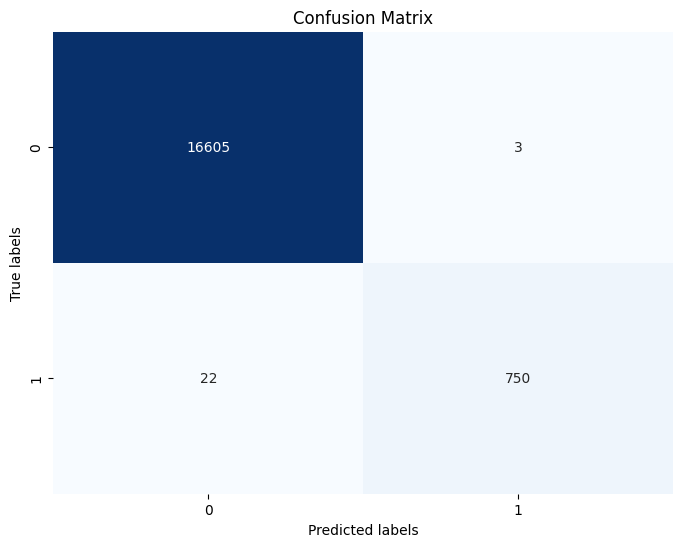

In [18]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

<Figure size 1000x800 with 0 Axes>

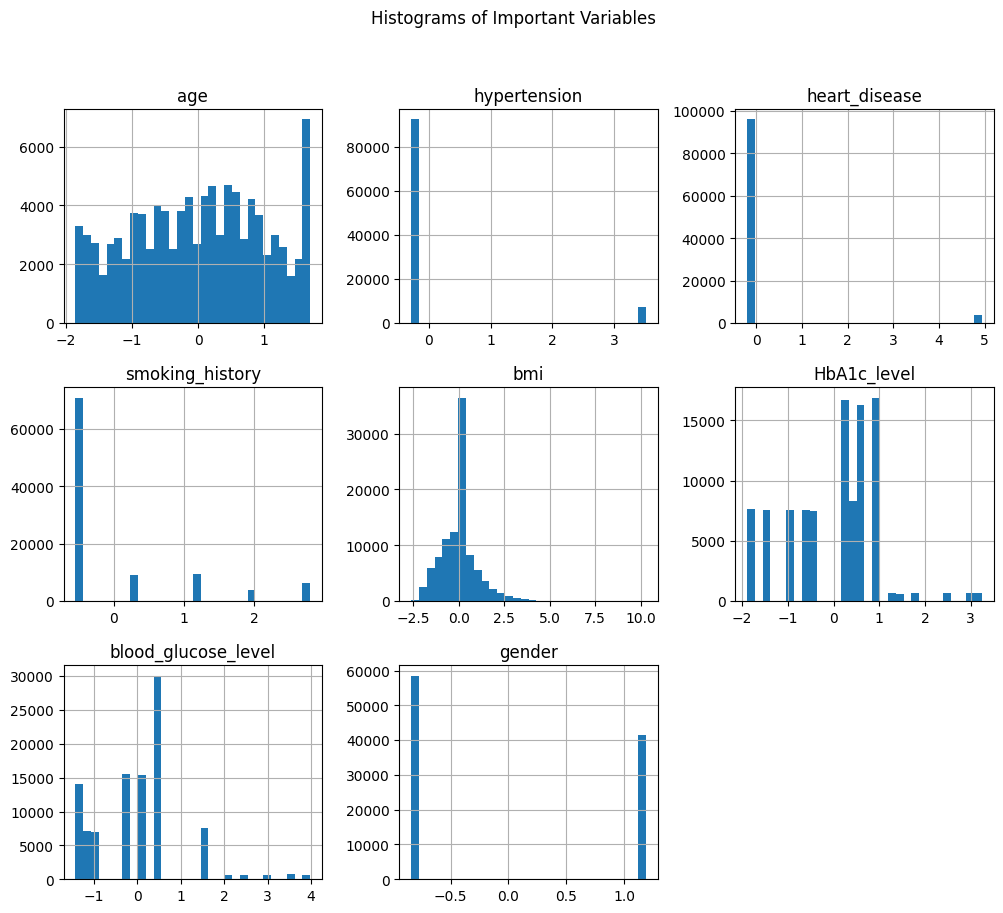

In [19]:
# Plot histogram for important variables
plt.figure(figsize=(10, 8))
data[columns_to_normalize].hist(bins=30, figsize=(12, 10))
plt.suptitle("Histograms of Important Variables")
plt.show()

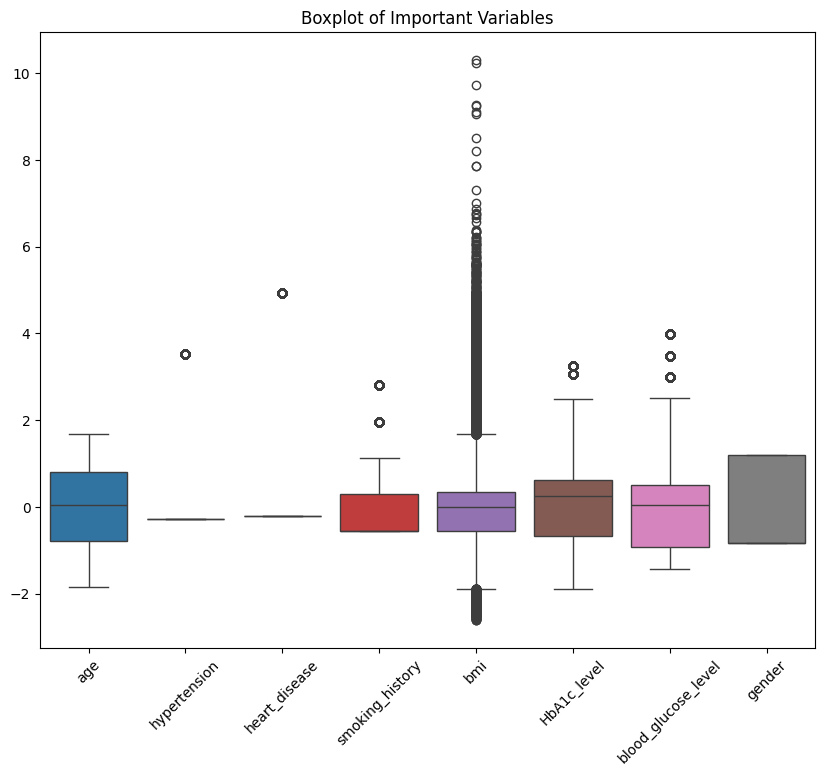

In [20]:
# Plot boxplot for important variables
plt.figure(figsize=(10, 8))
sns.boxplot(data=data[columns_to_normalize])
plt.title("Boxplot of Important Variables")
plt.xticks(rotation=45)
plt.show()

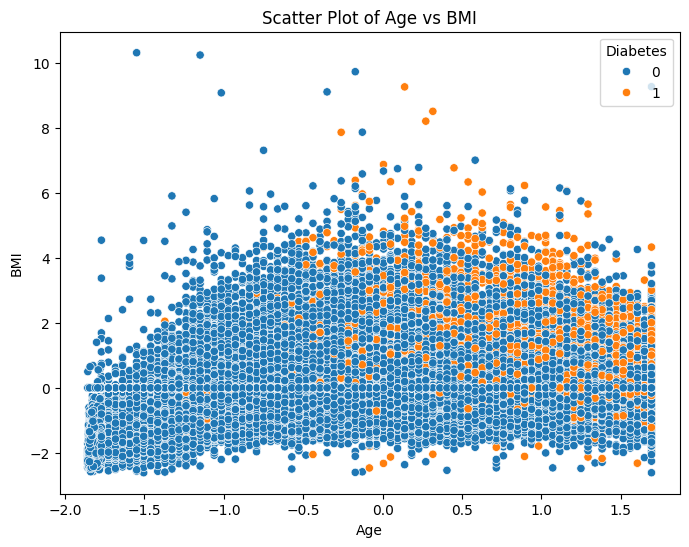

In [21]:
# Plot scatter plot for age vs BMI
plt.figure(figsize=(8, 6))
sns.scatterplot(data=data, x='age', y='bmi', hue='diabetes')
plt.title("Scatter Plot of Age vs BMI")
plt.xlabel("Age")
plt.ylabel("BMI")
plt.legend(title='Diabetes')
plt.show()

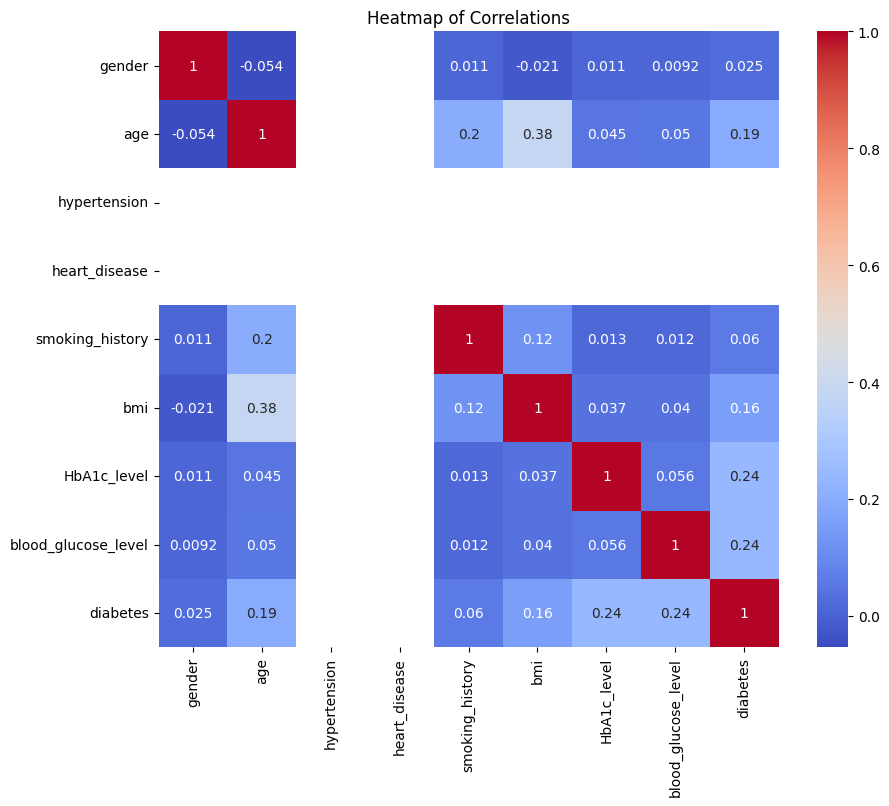

In [22]:
# Plot heatmap of correlations
plt.figure(figsize=(10, 8))
corr_matrix = cleaned_data.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Heatmap of Correlations")
plt.show()
